<a href="https://colab.research.google.com/github/HelgesenJ/ResearchProject/blob/master/TrainData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [17]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
print(tf.__version__)
import seaborn as sns
import datetime
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2.0.0


In [3]:
print ('Current date/time: {}'.format(datetime.datetime.now()))

Current date/time: 2019-11-20 14:58:20.369314


## Importing Data from GitHub

In [4]:
url = 'https://github.com/HelgesenJ/ResearchProject/blob/master/FilteredDataDatenum.csv?raw=true'
column_names = ['Datenum','Wind Speed','Wind Direction','Energy Generated']
df1 = pd.read_csv(url,names=column_names)
df1.head()

,Datenum,Wind Speed,Wind Direction,Energy Generated
0,737366.340278,6.04,115.6,0.0
1,737366.343750,0.00,0.4,0.0
2,737366.347222,0.00,0.4,0.0
3,737366.350694,0.00,0.4,0.0
4,737366.354167,0.00,0.4,0.0


Split data to train and test

In [0]:
train_dataset = df1.sample(frac=0.8,random_state=0)
test_dataset = df1.drop(train_dataset.index)

## Inspect data

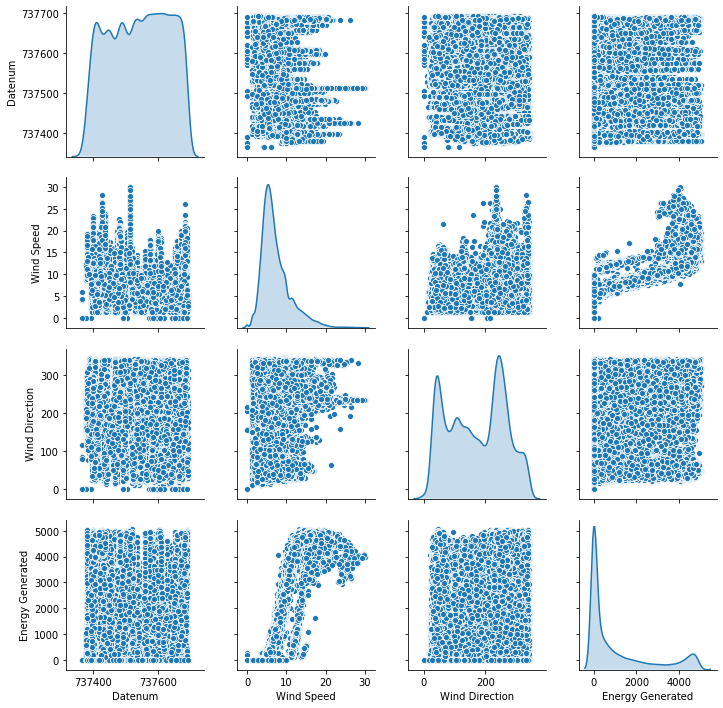

In [6]:
sns.pairplot(train_dataset, diag_kind="kde")

In [7]:
train_stats = train_dataset.describe()
train_stats.pop("Energy Generated")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Datenum,67578.0,737541.114617,89.632808,737366.340278,737463.448785,737544.303819,737618.40191,737691.996528
Wind Speed,67578.0,7.236438,3.648336,0.000000,4.780000,6.320000,8.85000,29.910000
Wind Direction,67578.0,171.976091,92.030933,0.000000,87.220000,176.745000,249.02000,343.550000


## Split features

In [0]:
train_labels = train_dataset.pop('Energy Generated')
test_labels = test_dataset.pop('Energy Generated')

## Normalize data (review)

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Build Model

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [13]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.0888911 ],
       [ 0.10443634],
       [ 0.23596403],
       [ 0.10229803],
       [ 0.01045149],
       [ 0.11879969],
       [ 0.0821117 ],
       [ 0.34994304],
       [ 0.11729433],
       [-0.05555464]], dtype=float32)

In [14]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,143804.528801,221.717545,143804.562500,149554.054333,219.257568,149554.046875,195
196,143949.377879,221.556488,143949.500000,153790.020115,231.443619,153790.015625,196
197,143909.002718,221.903961,143909.046875,152050.645198,218.116486,152050.656250,197
198,143700.037695,221.853485,143700.015625,148864.864319,219.617340,148864.859375,198
199,143926.313608,221.678604,143926.453125,150130.476593,219.047836,150130.468750,199


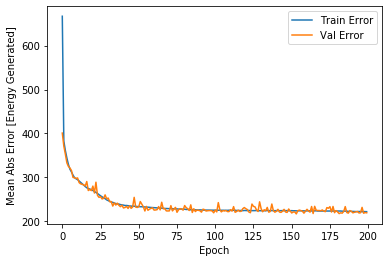

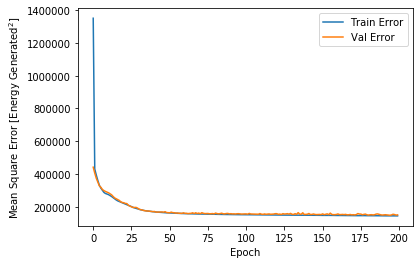

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Energy Generated]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [Energy Generated$^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
.........

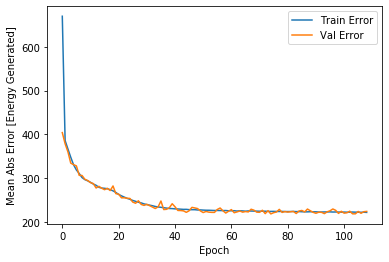

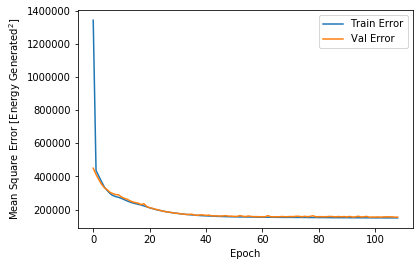

In [22]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [33]:
history.epoch[-1]

108

In [34]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Energy Generated".format(mae))

16895/16895 - 0s - loss: 148295.9637 - mae: 224.1176 - mse: 148295.9219
Testing set Mean Abs Error: 224.12 Energy Generated


UsageError: Line magic function `%lims` not found.


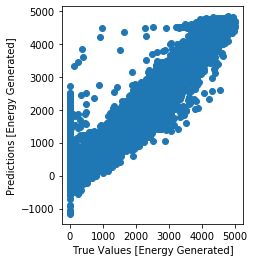

In [36]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Energy Generated]')
plt.ylabel('Predictions [Energy Generated]')
%lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

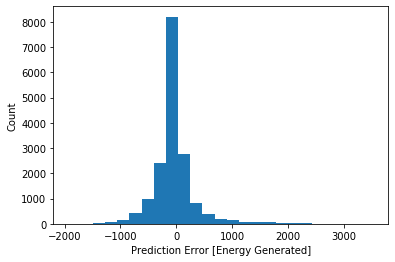

In [38]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Energy Generated]")
_ = plt.ylabel("Count")

In [50]:
a = np.array([[1,2,3],[4,5,6]])
print(a[1,:])

[4 5 6]


In [51]:
normed_test_data

,Datenum,Wind Speed,Wind Direction
2,-1.949815,-1.983490,-1.864331
10,-1.949505,-1.983490,-1.868677
13,-1.949389,-1.983490,-1.864765
20,-1.949118,-1.983490,-1.864331
21,-1.949079,-1.983490,-1.864331
...,...,...,...
84438,1.682016,-1.364029,-1.194121
84444,1.682249,-1.259872,-1.215744
84449,1.682443,-0.865172,-1.308539
84451,1.682520,-1.015926,-1.173585


In [0]:
testit = model.predict([])